In [1]:
import os
os.getcwd()

'g:\\Documents\\GitHub\\BiPAnalysisCodeShare\\forage_detect'

In [2]:
# DVLRead

from pathlib import Path
# bring in functions from main_func
from main_func import *
from math import pi
from scipy.signal import find_peaks
from scipy import stats
from sys import platform

import pandas as pd
import regex as re

# parent folder for all DVL data
if platform == 'darwin':
    dvlFolders = "/Users/aran/Documents/DVL"
else:
    dvlFolders = "E:/My Drive/PhD/Data/2018Shearwater/DVL"

In [3]:
dvlFolders

'E:/My Drive/PhD/Data/2018Shearwater/DVL'

In [4]:
# acc and vid starttimes
st17008 = [pd.to_datetime('31/08/2018 06:00:00', format = "%d/%m/%Y %H:%M:%S"),
           pd.to_datetime('31/08/2018 12:00:00', format = "%d/%m/%Y %H:%M:%S")]
st18012 = [pd.to_datetime('31/08/2018 04:00:00', format = "%d/%m/%Y %H:%M:%S"),
            pd.to_datetime('31/08/2018 10:00:00', format = "%d/%m/%Y %H:%M:%S")]
st18014 = [pd.to_datetime('31/08/2018 06:00:00', format = "%d/%m/%Y %H:%M:%S"),
            pd.to_datetime('31/08/2018 12:00:00', format = "%d/%m/%Y %H:%M:%S")]
st18017 = [pd.to_datetime('31/08/2018 04:00:00', format = "%d/%m/%Y %H:%M:%S"),
            pd.to_datetime('31/08/2018 11:00:00', format = "%d/%m/%Y %H:%M:%S")]
st18018 = [pd.to_datetime('31/08/2018 04:00:00', format = "%d/%m/%Y %H:%M:%S"),
            pd.to_datetime('31/08/2018 12:00:00', format = "%d/%m/%Y %H:%M:%S")]
starttimes = [st17008,st18012,st18014,st18017,st18018]

tagnames = ['17008','18012','18014','18017','18018']

# dictionaries storing start times (acceleration [0], video [1])
tagInfo = dict(zip(tagnames,starttimes))

# initialise dictionary
tagData = {}

# read in the video behaviour records
if platform.startswith('win'):
    behav_class_loc = 'E:/My Drive/PhD/Data/2018Shearwater/DVL/DiveBehavClass.csv'
else:
    behav_class_loc = '/Users/aran/Library/CloudStorage/GoogleDrive-aran.garrod@googlemail.com/My Drive/Data/DVL/DiveBehavClass.csv'
behavClass = pd.read_csv(behav_class_loc, sep = ',', usecols = [0,1,2,4], dtype = {'Tag' : str})

# replace 'Dive' behaviour with 's' (surface) or 'd' (dive)
behavClass.loc[behavClass['Behaviour'] == 'Dive','Behaviour'] = behavClass.loc[behavClass.Behaviour == 'Dive','ForageBeh']
# remove superfluous column
behavClass.drop('ForageBeh',axis = 1, inplace = True)

# set time to datetime
behavClass.Time = pd.to_datetime('31/08/2018 ' + behavClass.Time, format = '%d/%m/%Y %H.%M.%S.%f')


# path=Path(dvlFolders+"/18012/acc-video-2018-18012.txt")

for path in Path(dvlFolders).rglob('*acc*.txt'):
    
    print(f"Reading in acceleration data")
    # read in acceleration data
    dat = pd.read_table(path.__str__(), skiprows = 7, sep = ',', usecols = [0,1,2])

    # remove whitespace from headers
    dat.rename(columns=lambda x: x.strip(), inplace = True)

    # add time series
    dat['DT'] = pd.date_range(tagInfo[re.search(r"(\d{5}?).txt",path.name).group(1)][0], periods = len(dat), freq = '50ms')

    # select data within video range
    dat = dat[(dat.DT >= tagInfo[re.search(r"(\d{5}?).txt",path.name).group(1)][1]) & (dat.DT < tagInfo[re.search(r"(\d{5}?).txt",path.name).group(1)][1] + pd.Timedelta(hours=2))]

    # calculate pitch (clip array to min max of -1 1, assumes acceleration measured in g)
    print(f"Calculating acceleration features")
    dat = pd.concat([dat.reset_index(), accFeatures(dat[['X','Y','Z']],['Y','Z','X'],1.5,3,20)], axis = 1)
    tagname=re.search(r"(\d{5}?).txt",path.name).group(1)

    # generate spectrogram and summed spectral energy difference
    print(f"Generating spectrogram and spectral energy sums")
    f,s,Sxx = hammingSpect(dat.Z, fs = 20)
    rollSum = rollingSpecSum(Sxx, f, 3, 5, fs = 20)
    print(f"Performing roll sum")

    # extract behaviours for the specific tag
    bc = behavClass[behavClass.Tag == re.search(r"(\d{5}?).txt",path.name).group(1)]
    print(f"Popping behaviour classes")

    # remove minute containing AT behaviour
    print(f"Removing erroneous behaviour periods")
    if bc.Behaviour.eq('AT').any():
        print(f"AT present")
        behAT = np.any([(dat.DT >= (x - pd.Timedelta(30,'sec'))) & (dat.DT <= (x + pd.Timedelta(30,'sec'))) for x in bc.Time[bc.index[bc.Behaviour == 'AT']].round("s").values], axis = 0)

        rollSum[behAT[(2*20):-(2*20)+1]] = min(rollSum)
    
    print(f"Calculating {10} flight periods")

    flight_inds = maxWithGap(rollSum,20,numPoints=10)

    tagData[re.search(r"(\d{5}?).txt",path.name).group(1)] = {'acc' : dat, 'beh' : bc, 'fl_inds': flight_inds}

# returns dictionary for each tag, each contain two keys, 'acc' for acceleration data, 'beh' for video-derived behaviours. Data should be aligned.

# maxWithGap(rollSum,20,numPoints=10)



Reading in acceleration data
Calculating acceleration features
Generating spectrogram and spectral energy sums
Performing roll sum
Popping behaviour classes
Removing erroneous behaviour periods
AT present
Calculating 10 flight periods
Reading in acceleration data
Calculating acceleration features
Generating spectrogram and spectral energy sums
Performing roll sum
Popping behaviour classes
Removing erroneous behaviour periods
AT present
Calculating 10 flight periods
Reading in acceleration data
Calculating acceleration features
Generating spectrogram and spectral energy sums
Performing roll sum
Popping behaviour classes
Removing erroneous behaviour periods
AT present
Calculating 10 flight periods
Reading in acceleration data
Calculating acceleration features
Generating spectrogram and spectral energy sums
Performing roll sum
Popping behaviour classes
Removing erroneous behaviour periods
AT present
Calculating 10 flight periods
Reading in acceleration data
Calculating acceleration featur

In [5]:
# signal = tagData['18017']['acc'].Z
# fs=20
# behav_data = tagData['18017']['beh']
# dt = tagData['18017']['acc'].DT

test,_ = flightestimate(tagData['18017']['acc'].Z,20,tagData['18017']['beh'],tagData['18017']['acc'].DT,numPoints=10)

In [6]:
sig = tagData['18017']['acc'].Z
fs = 20
dt = tagData['18017']['acc'].DT
behav_data = tagData['18017']['beh']
numPoints=10
_,_,flap_sig = peak_trough(sig)
_,tst = flightestimate(sig,20,behav_data=behav_data,dt=dt,numPoints=numPoints)
tst = flap_sig + tst
peaks = np.where(tst == 2)[0]
troughs = np.where(tst == 3)[0]
# data = sig[peaks].values - sig[troughs].values
peaks
troughs

array([     3,      8,     13, ..., 143994, 143996, 143998], dtype=int64)

In [7]:
flap_sig.shape
tst.shape

(144000,)

In [8]:
t1,t2 = flap(tagData['18017']['acc'].Z,20,10,4,True,tagData['18017']['beh'],
     tagData['18017']['acc'].DT,10)

In [9]:
_,_,flap_sig = peak_trough(tagData['18017']['acc'].Z)
_,tst = flightestimate(tagData['18017']['acc'].Z,20,tagData['18017']['beh'],tagData['18017']['acc'].DT,numPoints=10)
tst = flap_sig + tst
peaks = np.where(tst == 2)[0]
troughs = np.where(tst == 3)[0]
mags = tagData['18017']['acc'].Z

In [10]:
pitPeaks,pitTroughs,_ = peak_trough(tagData['18017']['acc'].pitch)
pitDiff = tagData['18017']['acc'].pitch[pitPeaks] - tagData['18017']['acc'].pitch[pitTroughs]
test

[array([129598, 129599, 129600, ..., 130755, 130756, 130757], dtype=int64),
 array([87559, 87560, 87561, ..., 88716, 88717, 88718], dtype=int64),
 array([3670, 3671, 3672, ..., 4827, 4828, 4829], dtype=int64),
 array([73845, 73846, 73847, ..., 75002, 75003, 75004], dtype=int64),
 array([12006, 12007, 12008, ..., 13163, 13164, 13165], dtype=int64),
 array([141144, 141145, 141146, ..., 142301, 142302, 142303], dtype=int64),
 array([29059, 29060, 29061, ..., 30216, 30217, 30218], dtype=int64),
 array([113698, 113699, 113700, ..., 114855, 114856, 114857], dtype=int64),
 array([56931, 56932, 56933, ..., 58088, 58089, 58090], dtype=int64),
 array([37191, 37192, 37193, ..., 38348, 38349, 38350], dtype=int64)]

## Identifying flapping

We use the doresoventral acceleration signal to identify flapping vs gliding/other behaviours. This signal, shown below, contains large changes in magnitude when the bird performs up or down strokes, with smaller changes during period of gliding. We will use this characteristic to isolate flapping signals.

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

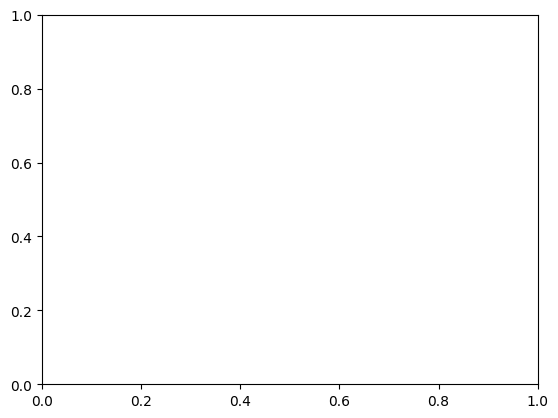

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

xformatter = mdates.DateFormatter('%H:%M:%S')
plt.plot(tagData['18017']['acc'].DT,tagData['18017']['acc'].Z,label='Dorsoventral acc',linewidth=.5)
plt.legend()
plt.xlim(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000])
plt.ylim(-1.5,3)
plt.xticks(np.datetime_as_string(np.arange(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000],np.timedelta64(20,'s')),unit='s'))
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

### Isolating signal extrema

Simply finding the peaks and troughs is trivial, shown below, but now flapping vs gliding signals must be separated.

In [ ]:
sig = tagData['18017']['acc'].Z
peaks,_ = find_peaks(sig)
troughs,_ = find_peaks(-sig)

if peaks[0] > troughs[0]:
    peaks.pop(0)
if peaks[-1] > troughs[-1]:
    peaks.pop(-1)

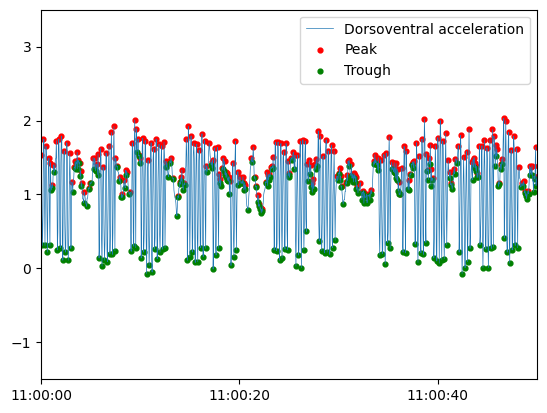

In [ ]:
plt.plot(tagData['18017']['acc'].DT,tagData['18017']['acc'].Z,label='Dorsoventral acceleration',linewidth=.5)
plt.scatter(tagData['18017']['acc'].DT[peaks],sig[peaks],c='r',label='Peak',s=12)
plt.scatter(tagData['18017']['acc'].DT[troughs],sig[troughs],c='g',label='Trough',s=12)
plt.legend()
plt.xlim(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000])
plt.ylim(-1.5,3.5)
plt.xticks(np.datetime_as_string(np.arange(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000],np.timedelta64(20,'s')),unit='s'))
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

### Using densities

If we take magnitude differences across peaks and troughs, we can generated a density estimate of this magnitude. We expect two peaks,representing the typical magnitude change during flapping (higher) vs gliding (lower). Assuming these represent typical magnitude changes between the two behaviours, we take the trough found between these two peaks, the inter-peak trough, as the treshold for a dorsoventral acceleration magnitude change that indicates a flap vs a glide:

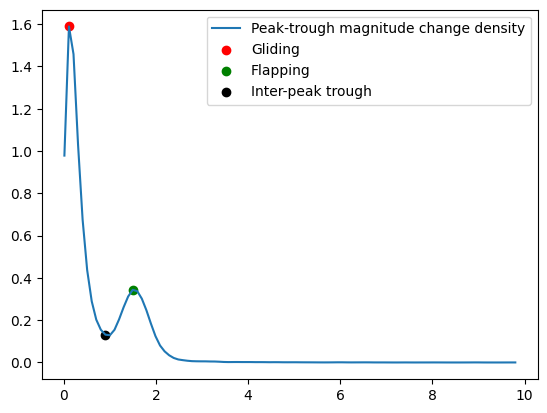

In [ ]:
data = sig[peaks].values - sig[troughs].values
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

ppeaks,_ = find_peaks(p)

# take first two peaks and find the trough inbetween
pks,_ = find_peaks(-p[ppeaks[0]:ppeaks[1]])

# retain only sufficiently large z displacements
large_inds = (sig[peaks].values - sig[troughs].values) > x[pks]

plt.plot(x,p,label='Peak-trough magnitude change density')
plt.scatter(x[ppeaks[0]],p[ppeaks[0]],c='r',label='Gliding')
plt.scatter(x[ppeaks[1]],p[ppeaks[1]],c='g',label='Flapping')
plt.scatter(x[pks],p[pks],c='k',label='Inter-peak trough')
plt.legend()

Sticking all this together, we now only keep peaks and troughs where the magnitude change exceeds this inter-peak trough, and this gives us a decent indication of when the bird was flapping, the number of times, how often etc.

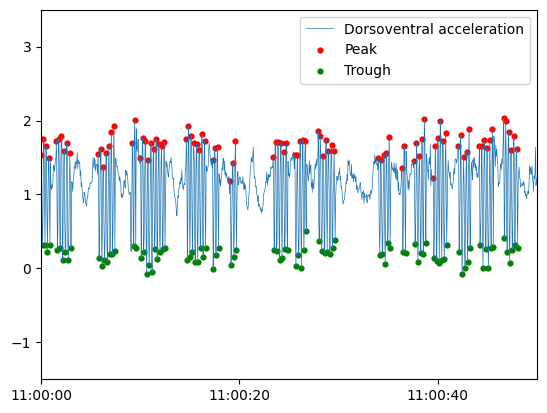

In [ ]:
plt.plot(tagData['18017']['acc'].DT,tagData['18017']['acc'].Z,label='Dorsoventral acceleration',linewidth=.5)
plt.scatter(tagData['18017']['acc'].DT[peaks[large_inds]],sig[peaks[large_inds]],c='r',label='Peak',s=12)
plt.scatter(tagData['18017']['acc'].DT[troughs[large_inds]],sig[troughs[large_inds]],c='g',label='Trough',s=12)
plt.legend()
plt.xlim(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000])
plt.ylim(-1.5,3.5)
plt.xticks(np.datetime_as_string(np.arange(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000],np.timedelta64(20,'s')),unit='s'))
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

### Flapping bouts

Finally, we can start grouping the flapping points together using prior knowledge about streaked shearwater typical flapping frequencies. Assume that birds will not flap outside of this 

In [ ]:
flapInds = np.sort(np.concatenate([peaks[large_inds],troughs[large_inds]]))

flap_gap = np.array([x-y for x,y in zip(flapInds[1:],flapInds)]) > (2*20/4)

flapInds[1:][flap_gap]

flapInds[29:33]
flapInds[1:10]


from itertools import compress
separators = np.array(list(compress(range(len(flap_gap)),flap_gap)))

# flapInds[0:9]

flap_mask = np.zeros(len(sig))
for x in range(len(separators)):
    if x == 0:
        flap_mask[flapInds[0]:separators[0]] = 1
    elif x < len(separators):
        flap_mask[flapInds[separators[x-1]:separators[x]]] = 1
# add final segment
flap_mask[flapInds[flapInds > flapInds[separators[-1]]][0]:flapInds[flapInds > flapInds[separators[-1]]][-1]] = 1

In [ ]:
len(flapInds)

22954

In [ ]:
def find_gaps(signal, gap_size):
    """Identify gaps in bool array `signal` greater than `gap_size` in length. Extend True segments to contain all elements contained within gap.

    Returns bool array with fully extended True bouts.
    """
    past_threshold = np.array([x-y for x, y in zip(signal[1:],signal)]) > gap_size
    past_threshold = np.array(list(compress(range(len(past_threshold)),past_threshold)))
    # ends = past_threshold.append(len(flapInds))
    ends = np.append(past_threshold,(len(signal)-1))
    starts = np.insert(past_threshold + 1,0,0)
    # mask = np.zeros(ends[-1]).astype(int)
    # for x,y in zip(starts,ends):
    #     mask[x:y] = 1
    return signal[starts],signal[ends]

This whole sequence of calculations are put together in the `flap` and `find_gaps` functions:

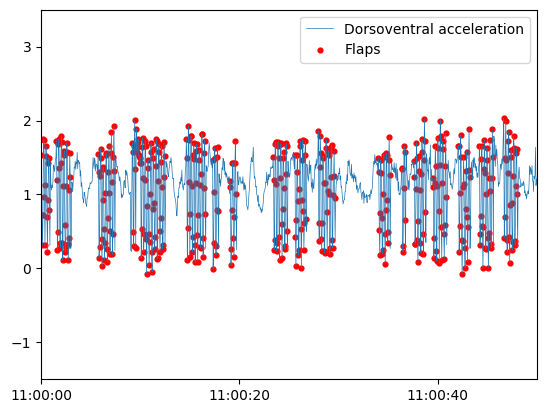

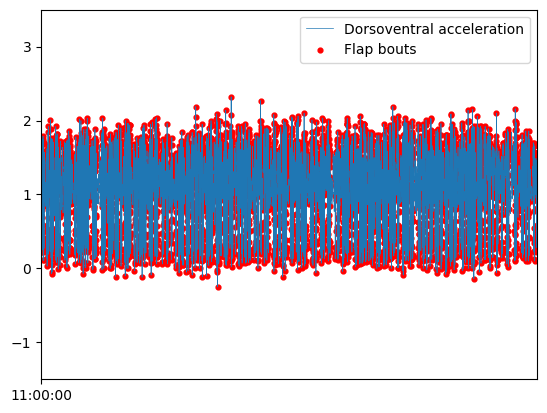

In [ ]:
flap_mask, flap_bouts = flap(tagData['18017']['acc'].Z, fs=20, bout_gap=5, flap_freq=4)

plt.figure()
plt.plot(tagData['18017']['acc'].DT,tagData['18017']['acc'].Z,label='Dorsoventral acceleration',linewidth=.5)
plt.scatter(tagData['18017']['acc'].DT[flap_mask==1],sig[flap_mask==1],c='r',label='Flaps',s=12)
plt.legend()
plt.xlim(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000])
plt.ylim(-1.5,3.5)
plt.xticks(np.datetime_as_string(np.arange(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[1000],np.timedelta64(20,'s')),unit='s'))
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

plt.figure()
plt.plot(tagData['18017']['acc'].DT,tagData['18017']['acc'].Z,label='Dorsoventral acceleration',linewidth=.5)
plt.scatter(tagData['18017']['acc'].DT[flap_bouts==1],sig[flap_bouts==1],c='r',label='Flap bouts',s=12)
plt.legend()
plt.xlim(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[10000])
plt.ylim(-1.5,3.5)
plt.xticks(np.datetime_as_string(np.arange(tagData['18017']['acc'].DT[0],tagData['18017']['acc'].DT[10000],np.timedelta64(20,'m')),unit='m'))
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

In [ ]:
dat = tagData['18018']['acc']
beh = tagData['18018']['beh']
_,fl_inds = flightestimate(dat.Z,20,behav_data=beh,dt=dat.DT,gap=30,cat='AT',low=3,high=5,removeErr=True,window=60,minGap=5,numPoints=10)
# _,_,pit_sig = peak_trough(dat.pitch)
# # find overlap with flights
# fl_pit_pk = np.where(pit_sig + fl_inds == 2)
# fl_pit_trgh = np.where(pit_sig + fl_inds == 2)

No erroneous data found


AttributeError: 'NoneType' object has no attribute 'copy'

In [ ]:
f,_,Sxx = hammingSpect(dat.Z,20)
rollSum = rollingSpecSum(Sxx, f, 3, 5, 20)
print(rollSum)
# if removeErr:
# rollSum = reduceErroneous(rollSum,beh,dat.DT,20,30,'AT')
# out = maxWithGap(rollSum,20,60,5,10)
# flight = np.zeros(len(signal))
# for x in out:
#     flight[x] = 1

0           0.455499
1           0.945998
2           1.470405
3           2.029748
4           2.620639
             ...    
143916    583.468941
143917    584.230907
143918    584.997641
143919    585.762220
143920    586.518499
Length: 143921, dtype: float64


### MATLAB DVL process

For each tag:

**1. Define static/dynamic acceleration - `lowEquiFilt()`**

**2. Calculate pitch, roll, yaw, ODBA - `accFeatures()`**

**3. Find 10 flying estimate minutes (compare energies in Z axis for 3-5 and 5+ Hz) `fl_inds` at least 5 minutes apart and reduce magnitudes of minutes containing 'AT' behaviours - `flightestimate()`**

**4. Find peaks/troughs of pitch signal and calculate magnitude difference**

5. Collect magnitude differences within `fl_inds` minutes, `pitFL`
   
6. Extract 1.5 * median value of max `pitFL` from each minute, `toEx`
   
7.  Take median of `toEx` across all DVL tags

For each tag:

1. Repeat steps 1-4 above
2. Calculate `movSg`, median of the max of 2-second moving variance of dynamic Y for each `fl_inds`
3. `ODmFL` the median of `ODmn`, minimum 10-second moving mean of ODBA for each `fl_inds`
4. `pitFLmn` the median of max `pitMn`, 10-second moving mean of pitch for each `fl_inds`
5. `pitVar` the median of `pitVar`, variance of pitch for each `fl_inds`
6. Define `EthBeh`, empty string array of same length as data
7. Find where `ODmn` $<0.2$ and define these periods as 'Rest' in `EthBeh`
8. `DiveUp`, median of mean of pitch for each `fl_inds` $+ 2\times$the median of variance of pitch for each `fl_inds`
9. `DiveDown`, median of minimum pitch for each `fl_inds` - 30 (degrees)
10. Repeat step 5 from above
11. Find overlap with `fl_inds` for both peaks and troughs, `PeakIndFL` and `TroughIndFL`
12. Use `PeakIndFL` and `TroughIndFL` to generate density and calculate inter-peak interval
13. Remove glide peaks/troughs and group by typical flight frequency, `flaps`, and finally into bouts with gaps $<30$s, `FlDiff` (N.B. if no gaps found, set all `EthBeh` as 'FL')

In [ ]:
# DVL process
dat = load_DVL()
# extract behaviours for the specific tag
bc = behavClass[behavClass.Tag == re.search(r"(\d{5}?).txt",path.name).group(1)]
print(f"Popping behaviour classes")

# calculate pitch (clip array to min max of -1 1, assumes acceleration measured in g)
print(f"Calculating acceleration features")
dat = pd.concat([dat.reset_index(), accFeatures(dat[['X','Y','Z']],['Y','Z','X'],1.5,3,20)], axis = 1)

# estimate (10) flight minutes - gives array of 1/0
flight = flightestimate(dat.Z,fs,behav_data = beh, dt = dat.DT, gap = 30, cat = 'AT', low = 3, high = 5, removeErr = True, window = 60, minGap = 5, numPoints = 10)

# take pitch extrema
pitPeaks, pitTroughs, pit_sig = peak_trough(dat.pitch)



# generate spectrogram and summed spectral energy difference
print(f"Generating spectrogram and spectral energy sums")
f,s,Sxx = hammingSpect(dat.Z, fs = 20)
rollSum = rollingSpecSum(Sxx, f, 3, 5, fs = 20)
print(f"Performing roll sum")


# remove minute containing AT behaviour
print(f"Removing erroneous behaviour periods")
if bc.Behaviour.eq('AT').any():
    print(f"AT present")
    behAT = np.any([(dat.DT >= (x - pd.Timedelta(30,'sec'))) & (dat.DT <= (x + pd.Timedelta(30,'sec'))) for x in bc.Time[bc.index[bc.Behaviour == 'AT']].round("s").values], axis = 0)

    rollSum[behAT[(2*20):-(2*20)+1]] = min(rollSum)

print(f"Calculating {10} flight periods")

flight_inds = maxWithGap(rollSum,20,numPoints=10)

tagData[re.search(r"(\d{5}?).txt",path.name).group(1)] = {'acc' : dat, 'beh' : bc, 'fl_inds': flight_inds}

In [1]:
from birdTag import birdTag

In [2]:
file = "E:/My Drive/PhD/Data/2018Shearwater/DVL/18018/acc-video-2018-18018.txt"
long_acc_name = ['Y','X','Z']
behLoc = 'E:/My Drive/PhD/Data/2018Shearwater/DVL/DiveBehavClass.csv'
test = birdTag(filepath=file,type='dvl',tagname='18018',accfs=20,long_acc_name=long_acc_name,accStart='31/08/2018 06:00:00',vidStart='31/08/2018 12:00:00')

In [5]:
# read in acceleration data
test.readin(vidOnlyPeriod=True)
# read in behavioural data
test.readBeh(behavPath=behLoc)
# # add acceleration features
test.accFeatures(passband=1.5,stopband=3)
# add rolling sum of frequency content of Z axis
test.rollSum(minfreq=3,maxfreq=5)
# estimate 10 minutes of flight
test.flight_est(numPoints=10,removeErr=True)
# # generate flapping masks of Z axis accel
test.flapping()
# # produce pitch and ODBA variables from flight periods
test.pitchPT()

,index,X,Y,Z,DT,pitch,ODBA,surge,DZ,pitmn,ODmn
0,432000,0.05,0.04,1.51,2018-08-31 12:00:00.000,2.292447,0.000003,-7.522211e-08,-9.402764e-08,2.292447,0.000003
1,432001,-0.11,-0.05,1.47,2018-08-31 12:00:00.050,-0.561862,0.216923,-4.019381e-02,-1.099489e-01,0.865292,0.108463
2,432002,-0.13,-0.09,1.29,2018-08-31 12:00:00.100,-2.969531,0.151126,-3.819511e-02,-8.654020e-02,-0.412982,0.122684
3,432003,-0.01,-0.13,1.22,2018-08-31 12:00:00.150,-4.620107,0.156631,-4.945128e-02,6.502616e-02,-1.464763,0.131171
4,432004,0.00,-0.08,1.22,2018-08-31 12:00:00.200,-5.419528,0.128039,1.444762e-02,9.204351e-02,-2.255716,0.130545
...,...,...,...,...,...,...,...,...,...,...,...
143995,575995,-0.08,-0.07,1.24,2018-08-31 13:59:59.750,-4.526986,0.044075,8.928627e-03,-2.147357e-02,-3.412764,0.231785
143996,575996,-0.01,-0.10,1.30,2018-08-31 13:59:59.800,-4.609671,0.084725,-1.963284e-02,4.670018e-02,-3.420165,0.231948
143997,575997,-0.13,-0.08,1.28,2018-08-31 13:59:59.850,-4.960629,0.093773,6.471179e-03,-8.266246e-02,-3.428623,0.231674
143998,575998,-0.08,-0.04,1.33,2018-08-31 13:59:59.900,-5.562274,0.171766,5.692759e-02,-4.916972e-02,-3.439951,0.231416


In [31]:
# import numpy as np
# np.sum(test.flight)
# len(test.acc)
# test.acc
import utils.analyseAcc as accFn
pks,troughs = accFn.peak_trough_in_flight(test.acc.Z,test.flInds)

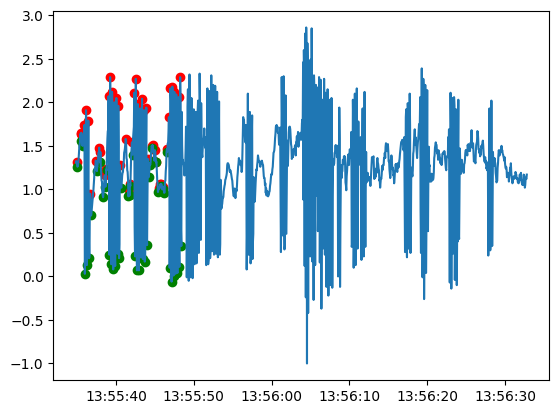

In [42]:
plt.plot(test.acc.DT[test.flInds[0]].values,test.acc.Z[test.
flInds[0]].values)

plt.scatter(test.acc.DT[pks[0:50]].values,
            test.acc.Z[pks[0:50]].values,c='r')
plt.scatter(test.acc.DT[troughs[0:50]].values,
            test.acc.Z[troughs[0:50]].values,c='g')

([<matplotlib.axis.XTick at 0x230b15ea520>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

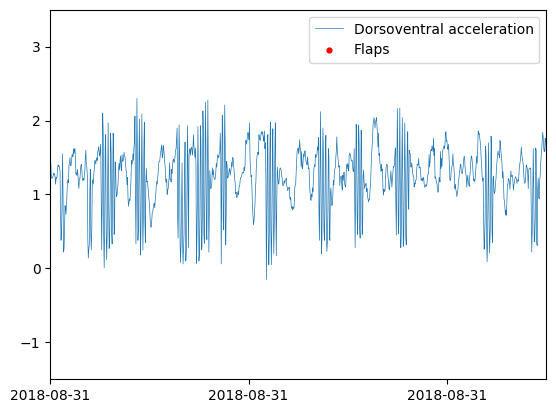

In [27]:
# import matplotlib.pyplot as plt

plt.plot(np.array(test.acc['DT']),np.array(test.acc['Z']),label='Dorsoventral acceleration',linewidth=.5)
plt.scatter(test.acc.DT[test.flight==1],test.acc.Z[test.flight==1],c='r',label='Flaps',s=12)
plt.legend()
plt.xlim(test.acc.DT[0],test.acc.DT[1000])
plt.ylim(-1.5,3.5)
plt.xticks(np.datetime_as_string(np.arange(test.acc.DT[0],test.acc.DT[1000],np.timedelta64(20,'s')),unit='s'))
# # plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

In [5]:
test.ODmFL

9.126531382186442e-06

In [17]:
import numpy as np
from statistics import median

median([np.mean(test.acc.pitch[x]) for x in test.flInds]) + 2*median([np.var(test.acc.pitch[x]) for x in test.flInds])
median([np.min(test.acc.pitch[x]) for x in test.flInds]) - 30

# DiveUp = (median(mean(Pitch(FLInds))) + 2*median(var(Pitch(FLInds))));
# DiveDown = median(min(Pitch(FLInds))) - 30;
print(len(test.flight),len(test.acc))

1048568 1048568
